# Louvain Performance Benchmarking

This notebook benchmarks performance improvement of running the Louvain clustering algorithm within cuGraph against NetworkX. The test is run over eight test networks (graphs) and then results plotted.  
<p><p>


#### Notebook Credits

    Original Authors: Bradley Rees
    Last Edit: 10/31/2019


#### Test Environment

    RAPIDS Versions: 0.10.0

    Test Hardware:
    GV100 32G, CUDA 10,0
    Intel(R) Core(TM) CPU i7-7800X @ 3.50GHz
    32GB system memory



#### Updates
- moved loading ploting libraries to front so that dependencies can be checked before running algorithms
- added edge values 
- changed timing to including Graph creation for both cuGraph and NetworkX.  This will better represent end-to-end times



#### Dependencies
- RAPIDS cuDF and cuGraph version 0.10.0 
- NetworkX 
- Matplotlib 
- Scipy 
- data prep script run



#### Note: Comparison against published results

The cuGraph blog post included performance numbers that were collected over a year ago.  For the test graphs, int32 values are now used.  That improves GPUs performance.  Additionally, the initial benchamrks were measured on a P100 GPU. 

This test only comparse the modularity scores and a success is if the scores are within 15% of each other.  That comparison is done by adjusting the NetworkX modularity score and then verifying that the cuGraph score is higher.

cuGraph did a full validation of NetworkX results against cuGraph results.  That included cross-validation of every cluster.  That test is very slow and not included here

## NOTICE: This benchamark can take several hours to run.  
A few of the tets graph can take over 4,000 seconds each for NetworkX to complete


In [1]:
#pip install cylouvain

In [2]:
# Import needed libraries
import time
import cugraph
import cudf

In [3]:
# NetworkX libraries
import community
import networkx as nx
from scipy.io import mmread

In [4]:
# CyLouvain - Cython wrapper to C for performance - See:  https://github.com/ahollocou/cylouvain
import cylouvain

In [5]:
# Loading plotting libraries
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

### Define the test data

In [6]:
# Test File
data = {
    'preferentialAttachment' : './data/preferentialAttachment.mtx',
    'caidaRouterLevel'       : './data/caidaRouterLevel.mtx',
    'coAuthorsDBLP'          : './data/coAuthorsDBLP.mtx',
    'dblp'                   : './data/dblp-2010.mtx',
    'citationCiteseer'       : './data/citationCiteseer.mtx',
    'coPapersDBLP'           : './data/coPapersDBLP.mtx',
    'coPapersCiteseer'       : './data/coPapersCiteseer.mtx',
    'as-Skitter'             : './data/as-Skitter.mtx'
}

### Define the testing functions

In [7]:
# Data reader - the file format is MTX, so we will use the reader from SciPy
def read_mtx_file(mm_file):
    print('Reading ' + str(mm_file) + '...')
    M = mmread(mm_file).asfptype()
     
    return M

In [8]:
def prep_mtx_data(M) :
    nnz_per_row = {r: 0 for r in range(M.get_shape()[0])}
    for nnz in range(M.getnnz()):
        nnz_per_row[M.row[nnz]] = 1 + nnz_per_row[M.row[nnz]]
    for nnz in range(M.getnnz()):
        M.data[nnz] = 1.0/float(nnz_per_row[M.row[nnz]])

    M = M.tocsr()
    if M is None:
        raise TypeError('Could not read the input graph')
    if M.shape[0] != M.shape[1]:
        raise TypeError('Shape is not square')

    # should be autosorted, but check just to make sure
    if not M.has_sorted_indices:
        print('sort_indices ... ')
        M.sort_indices()
        
    return M

In [9]:
# Run the cuGraph Louvain analytic (using nvGRAPH function)
def cugraph_call(M):

    print('\tcuGraph Solving... ')
    
    # data
    sources = cudf.Series(M.row)
    destinations = cudf.Series(M.col)
    data = cudf.Series(M.data)
  
    t1 = time.time()

    # create graph 
    G = cugraph.Graph()
    G.add_edge_list(sources, destinations, None)

    # cugraph Louvain Call
    df, mod = cugraph.louvain(G)   
    
    t2 = time.time() - t1
    
    del G
    
    return t2, mod


In [10]:
# Run the NetworkX Louvain analytic.  This is done in two parts since the modularity score is not returned 
def networkx_call(M):
    
    print('\tNetworkX Solving... ', end='')

    t1 = time.time()

    # Directed NetworkX graph
    print(' Gs', end='')
    Gnx = nx.Graph(M)
    print(' e ', end='')

    # Networkx 
    print(' 1s', end='')
    parts = community.best_partition(Gnx)
    print(' e ', end='')

    # Calculating modularity scores for comparison 
    mod = community.modularity(parts, Gnx)   
    
    print(' 2s', end='')
    t2 = time.time() - t1
    print(' e ')
    
    del Gnx
    
    return t2, mod

In [11]:
# Run the Cy-Louvain analytic.  This is done in two parts since the modularity score is not returned 
def cylouvain_call(M):
     
    print('\tCylouvain Solving... ', end=' ')

    t1 = time.time()

    # Directed NetworkX graph
    Gnx = nx.Graph(M)

    # Networkx 
    print(' 1 ', end='')
    parts = cylouvain.best_partition(Gnx)
    print(' 2 ', end='')

        
    # Calculating modularity scores for comparison 
    print(' 3 ', end='')
    mod = cylouvain.modularity(parts, Gnx)   
    print(' 4 ')
   
    t2 = time.time() - t1
    
    del Gnx
    
    return t2, mod

### Run the benchmarks

In [12]:
# Loop through each test file and compute the speedup
perf_nx = []
perf_cy = []
names = []

for k,v in data.items():

    names.append(k)
    
    iot1 = time.time()
    M = read_mtx_file(v)
    M2 = prep_mtx_data(M)  
    iot2 = time.time() - iot1
    
    tg, modg = cugraph_call(M)
    
    if len(M.row) < 2000000 :
        tn, modx = networkx_call(M2)
        speedUp_nx = (tn / tg)
        perf_nx.append(speedUp_nx)
        print("\t\t" + str(speedUp_nx) + "x faster =>  cugraph " + str(round(tg, 3)) + " vs " + str(round(tn,3)))
    else :
        perf_nx.append(0)
        

    tc, modc = cylouvain_call(M2)
    
    speedUp_cy = (tc / tg)
    perf_cy.append(speedUp_cy)       
    print("\t\t" + str(speedUp_cy) + "x faster =>  cugraph " + str(round(tg, 3)) + " vs " + str(round(tc,3)))

Reading ./data/preferentialAttachment.mtx...
	cuGraph Solving... 
	NetworkX Solving...  Gs e  1s e  2s e 
		1795.4017550391795x faster =>  cugraph 0.31 vs 556.437
	Cylouvain Solving...   1  2  3  4 
		86.92332646621239x faster =>  cugraph 0.31 vs 26.94
Reading ./data/caidaRouterLevel.mtx...
	cuGraph Solving... 
	NetworkX Solving...  Gs e  1s e  2s e 
		26892.88842645783x faster =>  cugraph 0.041 vs 1093.821
	Cylouvain Solving...   1  2  3  4 
		648.1360758751671x faster =>  cugraph 0.041 vs 26.362
Reading ./data/coAuthorsDBLP.mtx...
	cuGraph Solving... 
	NetworkX Solving...  Gs e  1s e  2s e 
		7354.454443845678x faster =>  cugraph 0.084 vs 614.968
	Cylouvain Solving...   1  2  3  4 
		471.16397649413636x faster =>  cugraph 0.084 vs 39.398
Reading ./data/dblp-2010.mtx...
	cuGraph Solving... 
	NetworkX Solving...  Gs e  1s e  2s e 
		5043.552869038876x faster =>  cugraph 0.094 vs 473.209
	Cylouvain Solving...   1  2  3  4 
		301.1379949127002x faster =>  cugraph 0.094 vs 28.254
Reading 

### plot the output

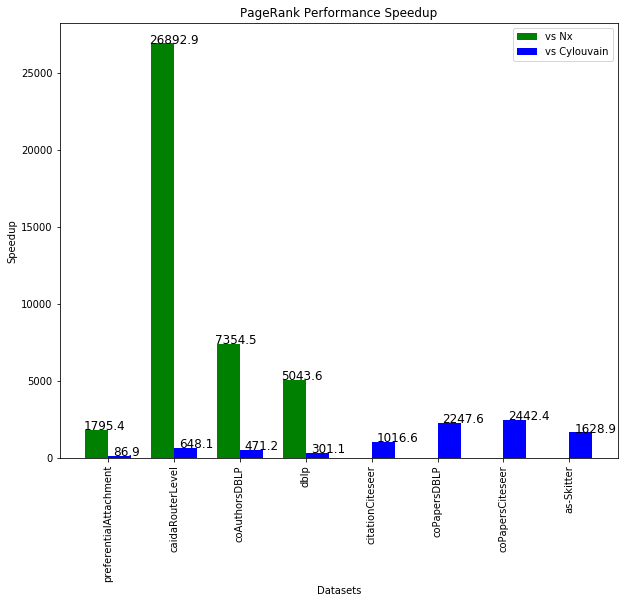

In [20]:
%matplotlib inline

plt.figure(figsize=(10,8))

bar_width = 0.35
index = np.arange(len(names))

_ = plt.bar(index, perf_nx, bar_width, color='g', label='vs Nx')
_ = plt.bar(index + bar_width, perf_cy, bar_width, color='b', label='vs Cylouvain')

plt.xlabel('Datasets')
plt.ylabel('Speedup')
plt.title('PageRank Performance Speedup')
plt.xticks(index + (bar_width / 2), names)
plt.xticks(rotation=90) 

# Text on the top of each barplot
for i in range(len(perf_nx)):
    if perf_nx[i] > 0 :
        plt.text(x = (i - 0.55) + bar_width, y = perf_nx[i] + 25, s = round(perf_nx[i], 1), size = 12)

for i in range(len(perf_cy)):
    plt.text(x = (i - 0.1) + bar_width, y = perf_cy[i] + 25, s = round(perf_cy[i], 1), size = 12)


plt.legend()
plt.show()